In [1]:
#Fahmi Nanda Saputro
#1103200203

In [2]:
#mengimport semua library yang digunakan untuk pengolahan data nanti
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D ,Dense ,Flatten ,Dropout ,MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
#import dataset yang sudah disimpan di Gdrive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#membuka file dataset yang sudah disimpan lalu train dan test file
training_file='/content/drive/MyDrive/dataset/train.p'
testing_file='/content/drive/MyDrive/dataset/test.p'

with open(training_file, mode='rb') as f:
  train=pickle.load(f)
with open(testing_file, mode='rb') as f:
  test=pickle.load(f)

print("Data Loaded")

Data Loaded


In [5]:
#mensetup sign name dari dataset
sign_name_df=pd.read_csv('/content/drive/MyDrive/dataset/signname.csv')
SIGN_NAMES=sign_name_df.SignName.values
sign_name_df.set_index('ClassId',inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [6]:
#menyiapkan matplotlib line
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [7]:
#Melakukan pemilihhan features dan label pada train
X ,y=train['features'], train['labels']

In [8]:
#menampilkan dimensi dari train
data=np.array(X)
labels=np.array(y)
print(data.shape,labels.shape)

(34799, 32, 32, 3) (34799,)


In [9]:
#melakukan pemilihan fitur
X_test ,y_test=test['features'],test['labels']

In [10]:
#menampilkan dimensi dari test
X_test=np.array(X_test)
y_test=np.array(y_test)
print(X_test.shape,y_test.shape)

(12630, 32, 32, 3) (12630,)


In [11]:
#pemisahan data train dan data valid
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=0.1,random_state=0 )
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


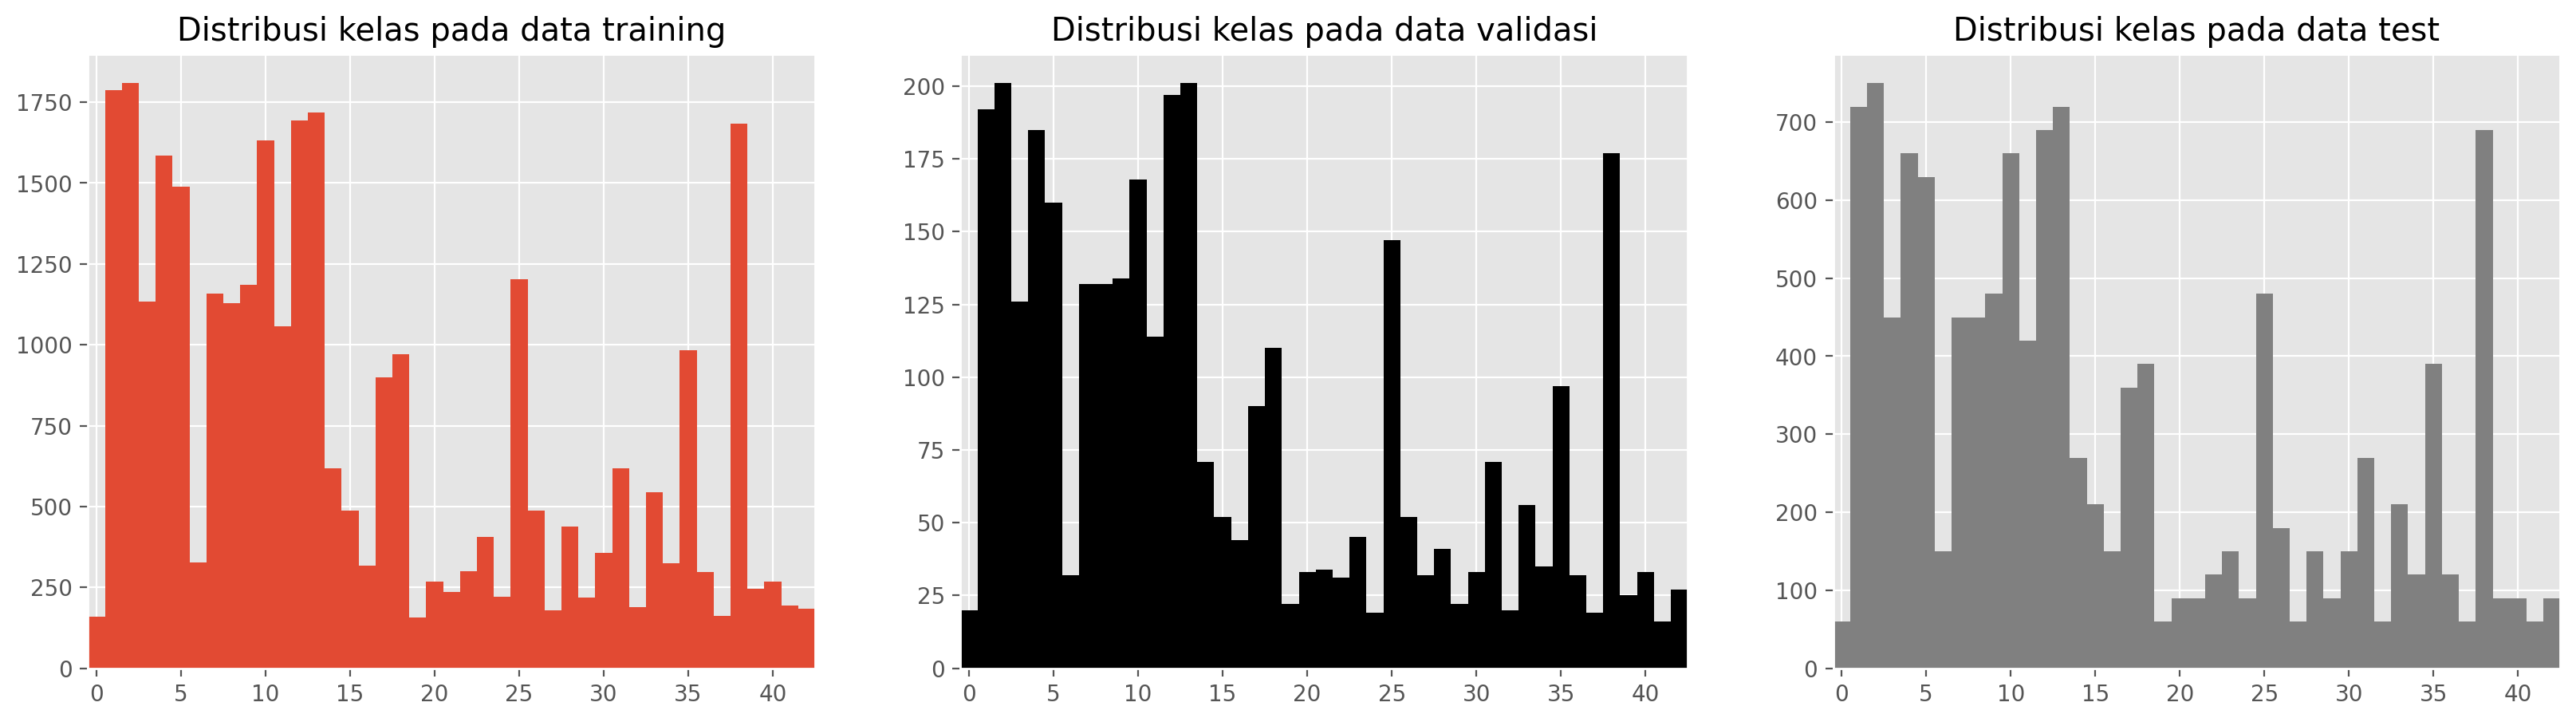

In [12]:
#pendistribusian kelas dari masing masing dataset
n_labels=np.unique(y_train).size
def hist_data(y_data,title=None,ax=None, **kwargs):
  if not ax:
    fig=plt.figure()
    ax=fig.add_subplot(111)
  ax.hist(y_data,np.arange(-0.5,n_labels+1.5),stacked=True,**kwargs)
  ax.set_xlim(-0.5,n_labels-0.5)
  if 'label' in kwargs:
    ax.legend()
  if title:
    ax.set_title(title)


fig,ax=plt.subplots(1,3,figsize=(20,5))
hist_data(y_train,title='Distribusi kelas pada data training',ax=ax[0])
hist_data(y_val,title='Distribusi kelas pada data validasi',ax=ax[1],color='black')
hist_data(y_test,title='Distribusi kelas pada data test',ax=ax[2],color='grey')

In [13]:
#mengkategorikan dari keras ke caterogical
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,43)
y_val=to_categorical(y_val,43)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

In [14]:
#membangun lapisan model
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [15]:
#menampilakn ringkasan dari model yang sudah dibuat
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [16]:
#melakukan set up compile, optimize, dan metrics
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
#melakukan pelatihan model dengan jumlah epoch 15 dan pelatihan dengan waktu 32
epochs = 15
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/15
979/979 [==============================] - 12s 6ms/step - loss: 1.7269 - accuracy: 0.5595 - val_loss: 0.4208 - val_accuracy: 0.9006
Epoch 2/15
979/979 [==============================] - 6s 6ms/step - loss: 0.5459 - accuracy: 0.8362 - val_loss: 0.1534 - val_accuracy: 0.9532
Epoch 3/15
979/979 [==============================] - 5s 5ms/step - loss: 0.3878 - accuracy: 0.8834 - val_loss: 0.1468 - val_accuracy: 0.9638
Epoch 4/15
979/979 [==============================] - 6s 6ms/step - loss: 0.3159 - accuracy: 0.9071 - val_loss: 0.1035 - val_accuracy: 0.9793
Epoch 5/15
979/979 [==============================] - 5s 5ms/step - loss: 0.2981 - accuracy: 0.9139 - val_loss: 0.1084 - val_accuracy: 0.9695
Epoch 6/15
979/979 [==============================] - 5s 5ms/step - loss: 0.2798 - accuracy: 0.9175 - val_loss: 0.1211 - val_accuracy: 0.9684
Epoch 7/15
979/979 [==============================] - 7s 7ms/step - loss: 0.2625 - accuracy: 0.9244 - val_loss: 0.1017 - val_accuracy: 0.9687
Epoch

In [18]:
#penyimpanan  model setelah pelatihan model dalam bentuk file .h5
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


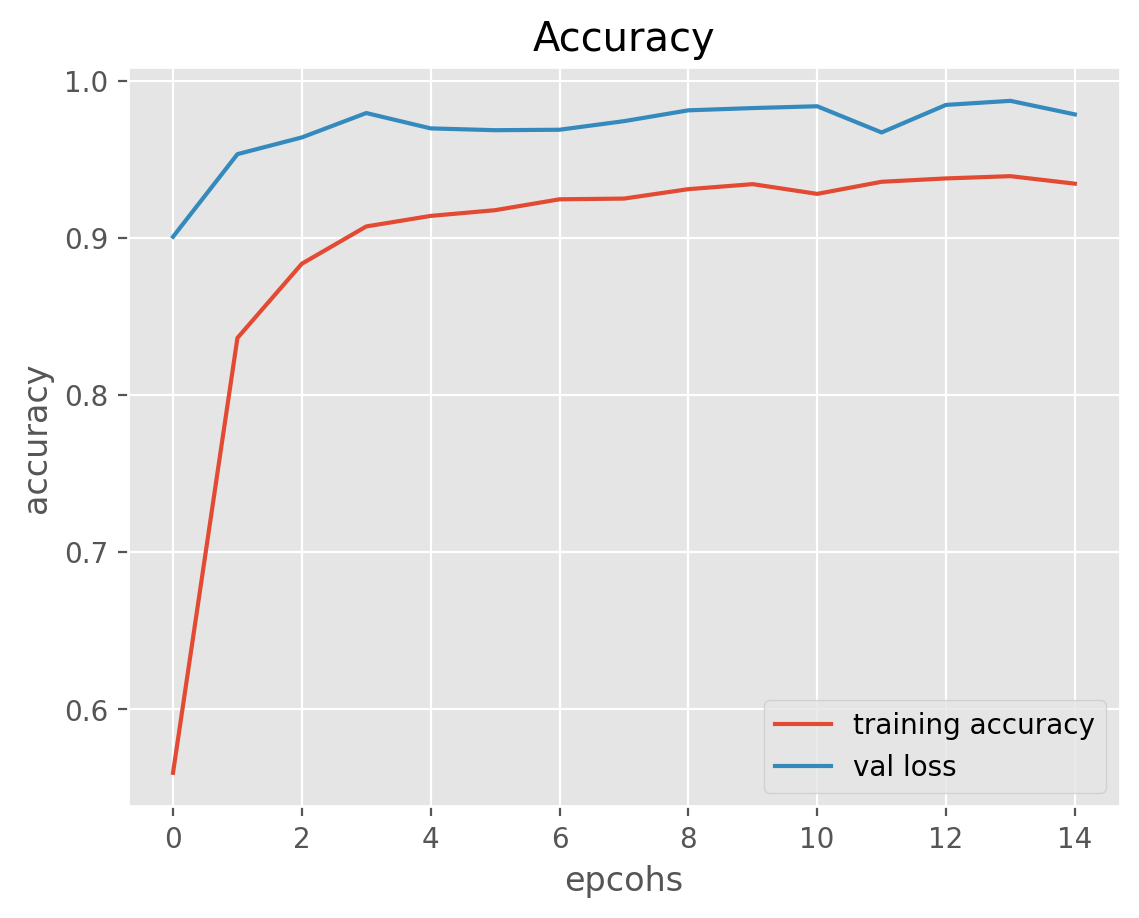

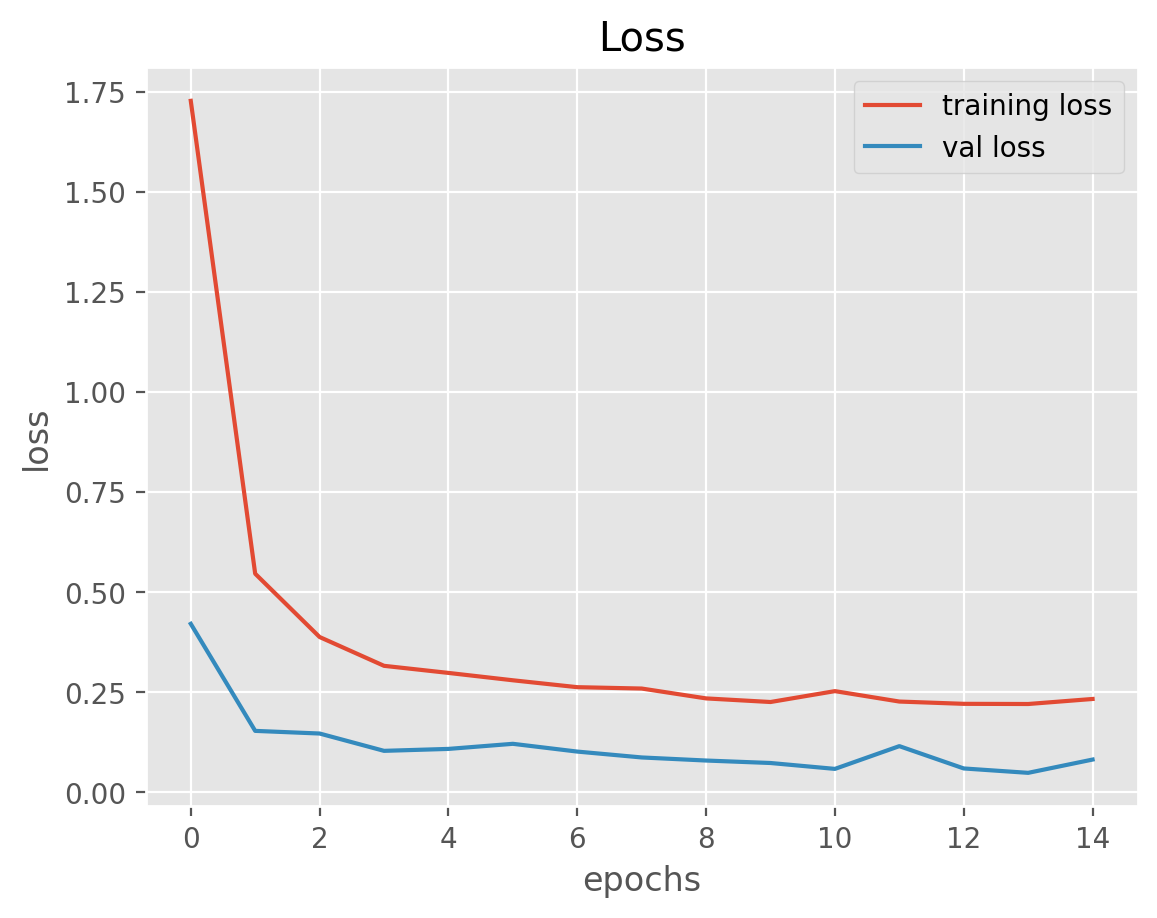

In [19]:
#melakukan visualisasi hasil setelah train dan dapat gradik hasil akurasi

plt.figure(0)
plt.plot(history.history['accuracy'],label='training accuracy')
plt.plot(history.history['val_accuracy'],label='val loss')
plt.title('Accuracy')
plt.xlabel('epcohs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [20]:
#melakukan evaluasi metrik dengan skor akurasi
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

395/395 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        60
           1       0.92      0.98      0.95       720
           2       0.94      0.93      0.94       750
           3       0.85      0.96      0.90       450
           4       0.97      0.95      0.96       660
           5       0.90      0.90      0.90       630
           6       1.00      0.86      0.92       150
           7       0.98      0.92      0.95       450
           8       0.95      0.98      0.96       450
           9       0.93      1.00      0.96       480
          10       0.99      0.98      0.98       660
          11       0.97      0.92      0.94       420
          12       0.99      0.96      0.98       690
          13       0.99      0.99      0.99       720
          14       0.98      0.97      0.98       270
          15       0.99      0.91      0.95       210
          16       0.98   